In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayesian_pdes as bpdes
from bayesian_pdes.util import plotting
plotting.monkeypatch_animation()
import numpy as np
import sympy as sp

In [14]:
Tend = 1.
L = 1.
bdy_heat = 0.5

In [15]:
def ic_fun(x):
    return np.zeros((x.shape[0], 1))

In [16]:
x, y, ls_x = sp.symbols('x, y, ls_x')
def A(k):
    return k.diff(x,x)
def A_bar(k):
    return k.diff(y,y)
def B(k):
    return k
def B_bar(k):
    return k

k = sp.exp(-(x-y)**2 / (2.*ls_x**2))
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy([A, B], [A_bar, B_bar], k, [[x], [y], [ls_x]])

In [17]:
dt = 0.01
dx = 0.01
theta = 0.0
target_dt = 0.01
skip = max(int(target_dt/dt), 1)

x_pts = np.arange(0,L+dx,dx)[:,None]
x_int = x_pts[1:-1,:]
x_bdy = x_pts[[0,-1], :]
times = np.arange(0,Tend+dt,dt)
def time_design_function(t):
    return x_int
def other_obs_function(t):
    bdy_term = bdy_heat*np.ones_like(x_bdy)
    return [(x_bdy, bdy_term)]

fun_args = np.array([2*dx])

In [18]:
ic = [(x_pts, ic_fun(x_pts))]

In [19]:
posteriors = bpdes.parabolic.solve_theta(
    [A, A_bar], 
    [[B], [B_bar]], 
    op_system, 
    time_design_function, 
    other_obs_function,
    ic,
    times,
    theta,
    fun_args
)

In [20]:
# deterministic solution by finite difference
import scipy.sparse, scipy.sparse.linalg
dt_det = 1e-4
alpha_det = 1.0
theta_det = 0.5
dx_det = 0.01

points_det = np.arange(0, L+dx_det, dx_det)

times_det = np.arange(0, Tend+dt_det, dt_det)
initial = ic_fun(points_det)
us = [initial]
u_curr = initial

ones = np.ones(points_det.shape[0])
main_mat = scipy.sparse.diags([-(1-theta_det)*alpha_det*ones[:-1]*dt_det/dx_det**2, 
                               1+2*(1-theta_det)*alpha_det*ones*dt_det/dx_det**2, 
                               -(1-theta_det)*alpha_det*ones[:-1]*dt_det/dx_det**2
                              ], [-1,0,1], format='csr')
rhs_mat = scipy.sparse.diags([theta_det*alpha_det*ones[:-1]*dt_det/dx_det**2, 
                               1 - 2*theta_det*alpha_det*ones*dt_det/dx_det**2, 
                               theta_det*alpha_det*ones[:-1]*dt_det/dx_det**2
                              ], [-1,0,1], format='csr')
main_mat[0,0] = 1.
main_mat[0,1] = 0.
main_mat[-1,-1] = 1.
main_mat[-1,-2] = 0.
rhs_mat[0,0] = 0
rhs_mat[0,1] = 0
rhs_mat[-1, -1] = 0
rhs_mat[-1, -2] = 0
for t in times_det[1:]:
    rhs = rhs_mat.dot(u_curr)
    rhs[0] = rhs[-1] = bdy_heat
    u_curr = scipy.sparse.linalg.spsolve(main_mat, rhs)
    us.append(u_curr)
det_skip = int(dt / dt_det)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [21]:
save_at = 'uninsulated_theta={}_dx={}_dt={}.mp4'.format(theta, dx, dt)
plt.xlim(0, L)
plt.ylim(0,1)
a = plotting.plot_parabolic_1d(x_pts, posteriors, times, stride=skip, deterministic=(points_det, us[::det_skip]))
#a.save(save_at, fps=20)
a

In [22]:
thetas = np.linspace(0,1,11)
dts = [0.1, 0.01, 0.001]
dx_perm = 0.001
permute_x_pts = np.arange(0,L+dx_perm,dx_perm)[:,None]
permute_x_int = permute_x_pts[1:-1,:]
permute_x_bdy = permute_x_pts[[0,-1], :]

def permute_time_design_function(t):
    return permute_x_int
def permute_other_obs_function(t):
    bdy_term = bdy_heat*np.ones_like(permute_x_bdy)
    return [(permute_x_bdy, bdy_term)]

permute_ic = [(permute_x_pts, ic_fun(permute_x_pts))]
permute_fun_args = np.array([2.*dx_perm])
dt_results = {}
for permute_dt in dts:
    theta_results = []
    for permute_theta in thetas:
        permute_times = np.arange(0, Tend+permute_dt, permute_dt)
        permute_posterior = bpdes.parabolic.solve_theta(
            [A, A_bar], 
            [[B], [B_bar]], 
            op_system, 
            permute_time_design_function, 
            permute_other_obs_function,
            permute_ic,
            permute_times,
            permute_theta,
            permute_fun_args,
            return_key='end'
        )
        mu, cov = permute_posterior(points_det[:,None])
        actual = us[-1]
        print permute_theta, permute_dt, np.sum((mu-actual)**2)
        theta_results.append(np.sum((mu-actual)**2))
    dt_results[permute_dt] = theta_results

0.0 0.1 0.0247444498635
0.1 0.1 0.0194264268527
0.2 0.1 0.0158542390757
0.3 0.1 0.0136669904986
0.4 0.1 0.0125940152381
0.5 0.1 0.0678801286455
0.6 0.1 105.685482002
0.7 0.1 9299.00135527
0.8 0.1 31292.5558287
0.9 0.1 834.016647453
1.0 0.1 391.118272749
0.0 0.01 0.0056160569692
0.1 0.01 0.00569539554005
0.2 0.01 0.00578828225157
0.3 0.01 0.00589553533798
0.4 0.01 0.00601407785856
0.5 0.01 0.00623958093827
0.6 0.01 68.2937254382
0.7 0.01 19.9402532861
0.8 0.01 47.216734627
0.9 0.01 80.0655415557
1.0 0.01 120.84150299
0.0 0.001 0.00617881980588
0.1 0.001 0.00620338156537
0.2 0.001 0.00622765959824
0.3 0.001 0.00625120533332
0.4 0.001 0.00627320047926
0.5 0.001 0.00629132131034
0.6 0.001 0.367893986017
0.7 0.001 2.74678185129
0.8 0.001 7.9341185273
0.9 0.001 15.4912200018
1.0 0.001 24.8344957529


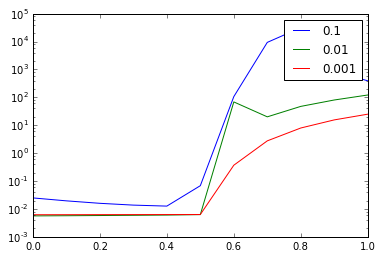

In [23]:
for dt in dts:
    plt.semilogy(thetas, dt_results[dt], label=dt)
    plt.legend()